# Sentiment analysis for r/WallStreetBets

### Preprocessing

In [20]:
### loading packages

import numpy as np 
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import re
import string
import warnings
from nltk import word_tokenize, corpus
warnings.simplefilter("ignore")
import nltk
from nltk import word_tokenize

### advanced below


In [ ]:
import nltk
sns.set_style('darkgrid')
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import Isomap
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
nltk.download('vader_lexicon')
from sklearn.cluster import KMeans
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud,STOPWORDS
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR,AutoReg
from nltk.util import ngrams

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import spacy as sp
nlps = sp.load('en')
import random

In [38]:
#import nltk
#nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Frederikke\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [5]:
### load data 
df=pd.read_csv("reddit_wsb.csv")

#dropping columns we don't need 
df.drop(columns=['id', 'url', 'created'], inplace=True)

#look at data
print(df.info())  
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38641 entries, 0 to 38640
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      38641 non-null  object
 1   score      38641 non-null  int64 
 2   comms_num  38641 non-null  int64 
 3   body       19244 non-null  object
 4   timestamp  38641 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.5+ MB
None


,title,score,comms_num,body,timestamp
0,"It's not about the money, it's about sending a...",55,6,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,23,NaN,2021-01-28 21:32:10
2,Exit the system,0,47,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,74,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,156,NaN,2021-01-28 21:26:56


### Clean the text 

* Data quality: https://www.kaggle.com/gpreda/wallstreetbets-reddit-posts-analysis#Sentiment-analysis
 > remove Nans
 > special characters 
 > upper/lower
 > lemma/token
 
 

https://www.kaggle.com/thomaskonstantin/reddit-wallstreetbets-posts-sentiment-analysis 


In [6]:
### clean it up 

title = df['title'].dropna()
body = df['body'].dropna()


def cleaner(text):
    text = text.lower()

    # Replacing Handlers with Empty String
    text = re.sub('@[^\s]+','',text)

    # Replacing URLs with Empty String
    text = re.sub(r"http\S+", "",text)

    # Remove all the special characters
    text = ' '.join(re.findall(r'\w+', text))

    # Replacing Single Characters with Empty String
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Removing Extra Spaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    return text

    
# Text Preprocessing
title = title.apply(lambda x : cleaner(x))
body = body.apply(lambda x : cleaner(x))


#put into original df
df['clean_title']=title
df['clean_body']=body

df.head()

,title,score,comms_num,body,timestamp,clean_title,clean_body
0,"It's not about the money, it's about sending a...",55,6,NaN,2021-01-28 21:37:41,it not about the money it about sending message,NaN
1,Math Professor Scott Steiner says the numbers ...,110,23,NaN,2021-01-28 21:32:10,math professor scott steiner says the numbers ...,NaN
2,Exit the system,0,47,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35,exit the system,the ceo of nasdaq pushed to halt trading to gi...
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,74,NaN,2021-01-28 21:28:57,new sec filing for gme can someone less retard...,NaN
4,"Not to distract from GME, just thought our AMC...",71,156,NaN,2021-01-28 21:26:56,not to distract from gme just thought our amc ...,NaN


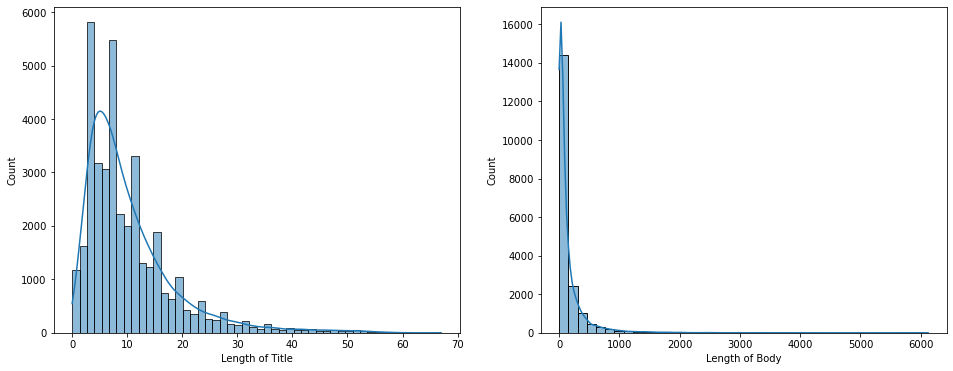

In [7]:
### investigate lengths of titles and bodies 

title_length = [len(word_tokenize(text)) for text in title]
body_length = [len(word_tokenize(text)) for text in body]

fig, (axis1, axis2) = plt.subplots(1,2, figsize=(16,6))

sns.histplot(title_length, bins=50, kde=True, ax=axis1)
sns.histplot(body_length, bins=40, kde=True, ax=axis2)

axis1.set_xlabel("Length of Title")
axis2.set_xlabel("Length of Body")

plt.show()

### THIS MIGHT BE IMPORTANT FOR NB ALGORITHM

### WordCloud for Title and Body of the Post

https://www.kaggle.com/sprakshith/beginner-s-guide-to-sentiment-analysis

For prevalent words

https://www.kaggle.com/gpreda/wallstreetbets-reddit-posts-analysis#Sentiment-analysis

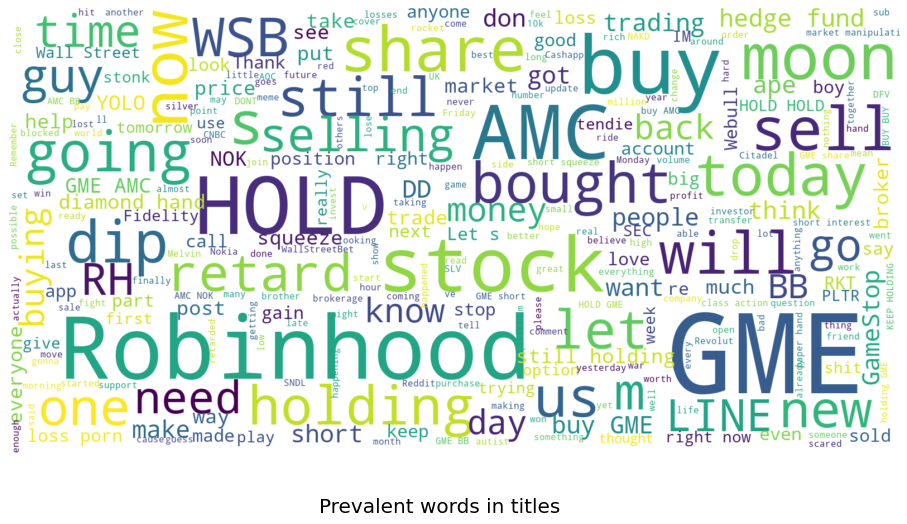

In [24]:
### Title Version 1 ###

def show_wordcloud(df, title=""):
    text = " ".join(t for t in df.dropna())
    stopwords = set(STOPWORDS)
    stopwords.update(["t", "co", "https", "amp", "U", "fuck", "fucking"])
    wordcloud = WordCloud(stopwords=stopwords, scale=4, max_font_size=50, max_words=500,background_color="white").generate(text)
    fig = plt.figure(1, figsize=(16,16))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()


show_wordcloud(df['title'], title = 'Prevalent words in titles')

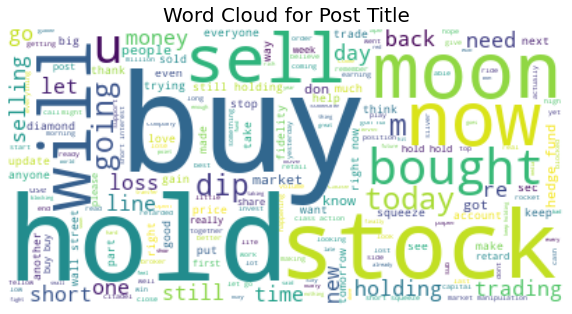

In [23]:
### Title Version 2 ###

english_words = set(corpus.words.words())
word_tokens = [word_tokenize(text) for text in title]

word_cloud_string = ""

for word_list in word_tokens:
    for word in word_list:
        if word.lower() in english_words:
            word_cloud_string += word + " "
        
# Updating some of the Words into Stopwords 
description_stopwords = set(STOPWORDS)

my_word_cloud = WordCloud(background_color='white',stopwords=description_stopwords).generate(word_cloud_string)
plt.figure(figsize=(10,20))
plt.imshow(my_word_cloud, interpolation='bilinear')
plt.title("Word Cloud for Post Title", fontsize=20)
plt.axis('off')
plt.show()

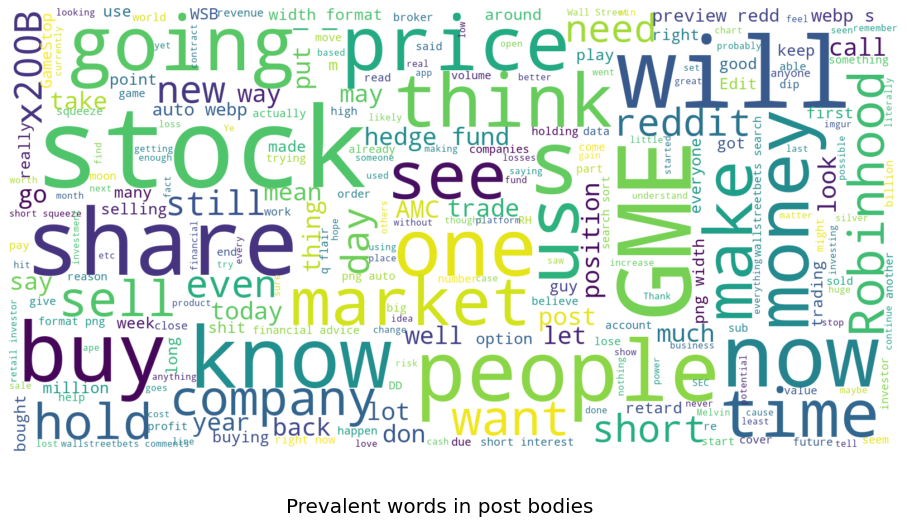

In [25]:
### Body Version 1 ###

show_wordcloud(df['body'], title = 'Prevalent words in post bodies')

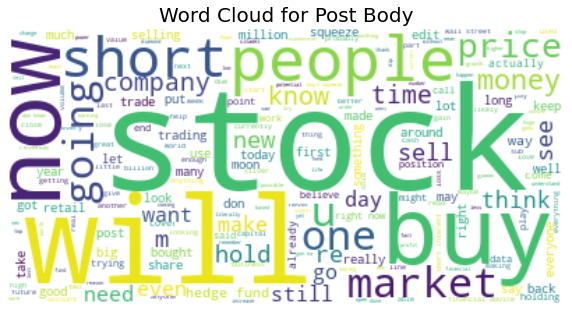

In [26]:
### Body Version 2 ###

word_tokens = [word_tokenize(text) for text in body]

word_cloud_string = ""

for word_list in word_tokens:
    for word in word_list:
        if word.lower() in english_words:
            word_cloud_string += word + " "
        
# Updating some of the Words into Stopwords 
description_stopwords = set(STOPWORDS)

my_word_cloud = WordCloud(background_color='white',stopwords=description_stopwords).generate(word_cloud_string)
plt.figure(figsize=(10,20))
plt.imshow(my_word_cloud, interpolation='bilinear')
plt.title("Word Cloud for Post Body", fontsize=20)
plt.axis('off')
plt.show()

### Sentiment analysis using 'SentimentIntensityAnalyzer' from nltk.sentiment

https://www.kaggle.com/sprakshith/beginner-s-guide-to-sentiment-analysis
https://www.kaggle.com/gpreda/wallstreetbets-reddit-posts-analysis#Sentiment-analysis

* WordCloud for Different Sentiment

In [38]:
# using the sentiment analysier from nltk.sentiment 
sia = SentimentIntensityAnalyzer() 

#make function 
def sentiment_score(sia, text): #takes the SentimentIntensityAnalyzer and some text 
    if sia.polarity_scores(text)["compound"] > 0: # if score above 0, label as posittive 
        return "Positive"
    elif sia.polarity_scores(text)["compound"] < 0: # if score below zero label negative 
        return "Negative"
    else:
        return "Neutral" # else, label Neutral

    

### use the sentiment_score fundction 

# create a df with the titels and the found sentiment lables 
title_df = title.to_frame(name='Title')
title_df['Sentiment'] = title_df['Title'].apply(lambda x : sentiment_score(sia, x))


# create a df with the bodies and the found sentiment lables 
body_df = body.to_frame(name='Body')
body_df['Sentiment'] = body_df['Body'].apply(lambda x : get_sentiment(sia, x))

Titles : Positive    9710
Negative    6310
Neutral     3224
Name: Sentiment, dtype: int64


In [87]:
### looking at sentiment 
#title 
title_sent_df=pd.DataFrame(title_df.groupby("Sentiment")["Sentiment"].count()).rename(columns={"Sentiment":"Count"}).reset_index().style.set_caption("Title sentiments")

title_sent_df

,Sentiment,Count
0,Negative,9380
1,Neutral,17793
2,Positive,11468


In [88]:
#body
body_sent_df=pd.DataFrame(body_df.groupby("Sentiment")["Sentiment"].count()).rename(columns={"Sentiment":"Count"}).reset_index().style.set_caption("Body sentiments")
#body_sent_df=bodye_sent_df.style.set_caption("Title sentiments")

body_sent_df

,Sentiment,Count
0,Negative,6310
1,Neutral,3224
2,Positive,9710


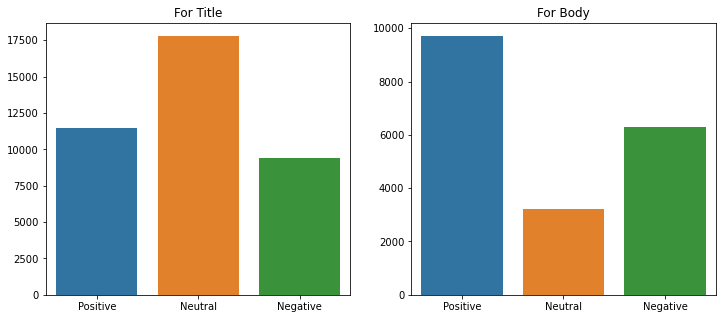

In [50]:
### Visualizations of the distribution of sentiment 

fig, (axis1, axis2) = plt.subplots(1,2, figsize=(12,5))
order = ['Positive', 'Neutral', 'Negative']

xs = title_df['Sentiment'].value_counts().index
ys = title_df['Sentiment'].value_counts().values
sns.barplot(x=xs, y=ys, order=order, ax=axis1)

xs = body_df['Sentiment'].value_counts().index
ys = body_df['Sentiment'].value_counts().values
sns.barplot(x=xs, y=ys, order=order, ax=axis2)

axis1.set_title("For Title")
axis2.set_title("For Body")

plt.show()

## Wordclouds for different sentiments

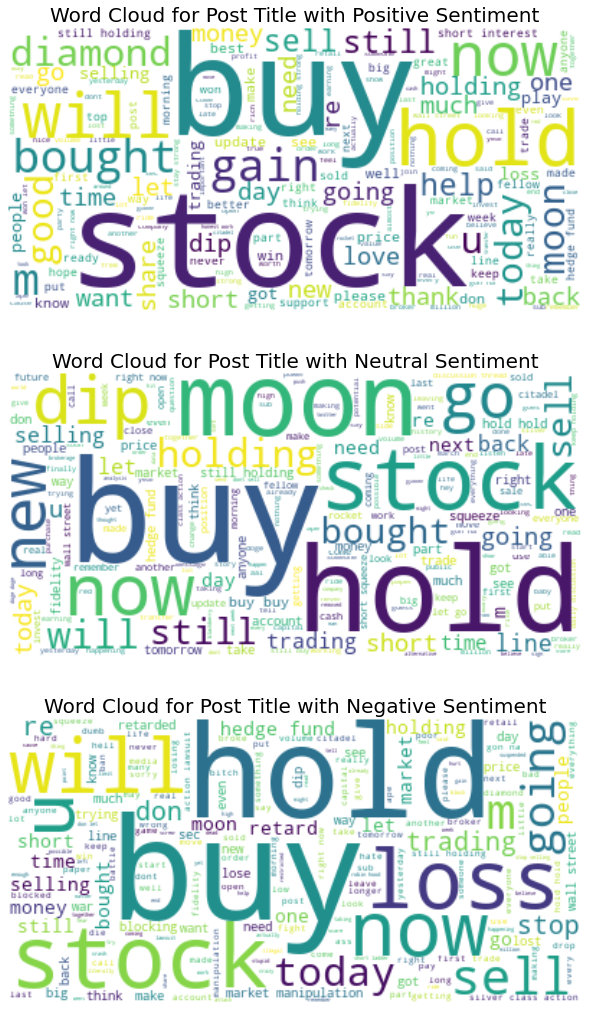

In [52]:
### Title clouds 

fig, (axis1, axis2, axis3) = plt.subplots(3, 1, figsize=(12,18))

axes = [axis1, axis2, axis3]
sentiments = ['Positive', 'Neutral', 'Negative']

for i in range(3):
    word_tokens = [word_tokenize(text) for text in title_df[title_df['Sentiment'] == sentiments[i]]['Title']]
    
    word_cloud_string = ""
    
    for word_list in word_tokens:
        for word in word_list:
            if word.lower() in english_words:
                word_cloud_string += word + " "
    
    description_stopwords = set(STOPWORDS)

    my_word_cloud = WordCloud(background_color='white',stopwords=description_stopwords).generate(word_cloud_string)
    axes[i].imshow(my_word_cloud, interpolation='bilinear')
    axes[i].set_title(f"Word Cloud for Post Title with {sentiments[i]} Sentiment", fontsize=20)
    axes[i].axis('off')


plt.show()

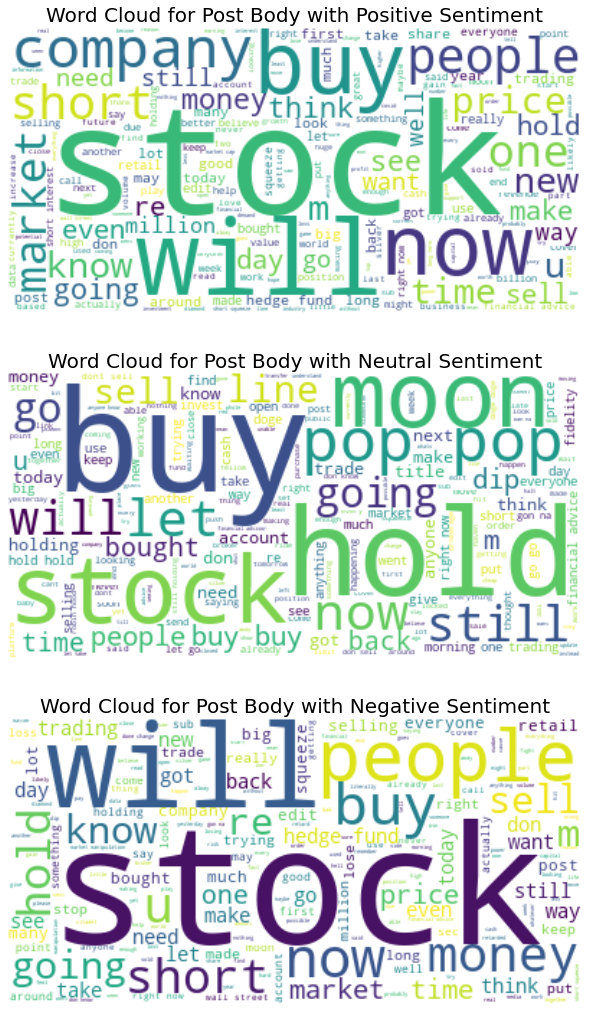

In [53]:
### Body clouds

fig, (axis1, axis2, axis3) = plt.subplots(3, 1, figsize=(12,18))

axes = [axis1, axis2, axis3]
sentiments = ['Positive', 'Neutral', 'Negative']

for i in range(3):
    word_tokens = [word_tokenize(text) for text in body_df[body_df['Sentiment'] == sentiments[i]]['Body']]
    
    word_cloud_string = ""
    
    for word_list in word_tokens:
        for word in word_list:
            if word.lower() in english_words:
                word_cloud_string += word + " "
    
    description_stopwords = set(STOPWORDS)

    my_word_cloud = WordCloud(background_color='white',stopwords=description_stopwords).generate(word_cloud_string)
    axes[i].imshow(my_word_cloud, interpolation='bilinear')
    axes[i].set_title(f"Word Cloud for Post Body with {sentiments[i]} Sentiment", fontsize=20)
    axes[i].axis('off')


plt.show()

In [63]:
title_df

,Title,Sentiment
0,it not about the money it about sending message,Neutral
1,math professor scott steiner says the numbers ...,Negative
2,exit the system,Neutral
3,new sec filing for gme can someone less retard...,Negative
4,not to distract from gme just thought our amc ...,Positive
...,...,...
38636,nclh yolo update,Positive
38637,adding to rkt 300 more to 1000 on morning pull...,Positive
38638,started at 5k few weeks ago now it time for th...,Positive
38639,posted yesterday about buying gme 104 122 94 f...,Positive


### Inspect text

* Avg. score for pos/neg/neu
* Avg. # for pos/neg/neu 
* when are the pos/negative posts made?
* Avg. number of comments per pos/neg/neu

# Creating and saving pdfs for titles and bodies with sentiment

In [90]:
title_df
body_df

,Body,Sentiment
2,the ceo of nasdaq pushed to halt trading to gi...,Negative
6,hedgefund whales are spreading disinfo saying ...,Negative
7,life isn fair my mother always told me that wh...,Negative
10,i believe right now is one of those rare oppor...,Positive
12,you guys are champs gme who would have thought...,Positive
...,...,...
38622,x200b,Neutral
38624,rkt as tech platform real estate doubled auto ...,Positive
38626,vonage is the 2nd largest ucaas unified commun...,Positive
38631,i don know if am an ape autist or retard ve be...,Positive


In [140]:
### adding sentiment and dropping columns for the title dataframe
title_sentiment = pd.concat([title_df, df], axis=1)

# dropping the columns we dont need
title_sentiment.drop(columns=['title', 'body', 'Title','clean_body'], inplace=True)

# check for NaNs
title_sentiment.info() # no NaNs

# look at the data
title_sentiment.head()

# create csv file 
#title_sentiment.to_csv('title_sentiment.csv',index=False )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38641 entries, 0 to 38640
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Sentiment    38641 non-null  object
 1   score        38641 non-null  int64 
 2   comms_num    38641 non-null  int64 
 3   timestamp    38641 non-null  object
 4   clean_title  38641 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.0+ MB


In [141]:
### combining the sentiment lables for the bodies to the df
body_sentiment = pd.concat([body_df, df], axis=1).dropna()

#dropping columns for the body dataframe
body_sentiment.drop(columns=['title','Body','body','clean_title'], inplace=True)

#checking for NaNs
body_sentiment.info() # no NaNs

#looking at data 
body_sentiment.head()

# create csv file 
#body_sentiment.to_csv('body_sentiment.csv',index=False )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19244 entries, 2 to 38635
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Sentiment   19244 non-null  object
 1   score       19244 non-null  int64 
 2   comms_num   19244 non-null  int64 
 3   timestamp   19244 non-null  object
 4   clean_body  19244 non-null  object
dtypes: int64(2), object(3)
memory usage: 902.1+ KB


,Sentiment,score,comms_num,timestamp,clean_body
2,Negative,0,47,2021-01-28 21:30:35,the ceo of nasdaq pushed to halt trading to gi...
6,Negative,317,53,2021-01-28 21:26:27,hedgefund whales are spreading disinfo saying ...
7,Negative,405,178,2021-01-28 21:19:31,life isn fair my mother always told me that wh...
10,Positive,222,70,2021-01-28 21:18:25,i believe right now is one of those rare oppor...
12,Positive,0,16,2021-01-28 21:17:10,you guys are champs gme who would have thought...


In [144]:
### make a clean text df 

df['clean_text'] = df['clean_body'] + df['clean_title']

df

,title,score,comms_num,body,timestamp,clean_title,clean_body,clean_text
0,"It's not about the money, it's about sending a...",55,6,NaN,2021-01-28 21:37:41,it not about the money it about sending message,NaN,NaN
1,Math Professor Scott Steiner says the numbers ...,110,23,NaN,2021-01-28 21:32:10,math professor scott steiner says the numbers ...,NaN,NaN
2,Exit the system,0,47,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35,exit the system,the ceo of nasdaq pushed to halt trading to gi...,the ceo of nasdaq pushed to halt trading to gi...
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,74,NaN,2021-01-28 21:28:57,new sec filing for gme can someone less retard...,NaN,NaN
4,"Not to distract from GME, just thought our AMC...",71,156,NaN,2021-01-28 21:26:56,not to distract from gme just thought our amc ...,NaN,NaN
...,...,...,...,...,...,...,...,...
38636,NCLH 💎🙌🚀🌕 YOLO update!!!,19,5,NaN,2021-03-04 01:27:07,nclh yolo update,NaN,NaN
38637,Adding to $RKT 300 more to 1000 on morning pul...,59,76,NaN,2021-03-04 01:19:25,adding to rkt 300 more to 1000 on morning pull...,NaN,NaN
38638,Started at 5k a few weeks ago. Now it’s time f...,44,26,NaN,2021-03-04 01:19:01,started at 5k few weeks ago now it time for th...,NaN,NaN
38639,Posted yesterday about buying GME 104 @ $122.9...,864,22,NaN,2021-03-04 01:17:22,posted yesterday about buying gme 104 122 94 f...,NaN,NaN
